# Learner

In [3]:
#| default_exp learner

In [4]:
#|export
import pickle, gzip, math, os, time, shutil, torch, matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager 

from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset, load_dataset_builder

from minai.datasets import *
from minai.conv import *

from fastprogress import progress_bar, master_bar

/home/studio-lab-user/.conda/envs/fastai/lib/python3.9/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.9.8) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [5]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(42)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

## Learner

In [6]:
x, y = 'image', 'label'
name = 'anubhavmaity/notMNIST'
dsd = load_dataset(name, download_mode="reuse_cache_if_exists")

Generating train split:   0%|          | 0/14979 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3745 [00:00<?, ? examples/s]

In [7]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [8]:
bs = 1024
tds = dsd.with_transform(transformi)

In [9]:
#|export
class DataLoaders:
    def __init__(self, *dls): self.train, self.valid = dls[:2]
        
    @classmethod
    def from_dd(cls, dd, batch_size, num_workers=4, as_tuple=True):
        return cls(*[DataLoader(ds, batch_size, collate_fn=collate_dict(ds)) for ds in dd.values()])

In [10]:
dls = DataLoaders.from_dd(tds, bs)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb[:10]

(torch.Size([1024, 784]), tensor([6, 9, 4, 8, 4, 0, 3, 3, 5, 2]))

In [11]:
#|export
class Learner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): fc.store_attr()
    
    def one_batch(self):
        self.xb, self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()
    
    def calc_stats(self):
        acc = (self.preds.argmax(dim=1) == self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)
    
    def one_epoch(self, train):
        self.accs, self.losses, self.ns = [], [], []
        self.model.train(train)
        dl = self.dls.train if train else self.dls.valid
        for self.num, self.batch in enumerate(dl): self.one_batch()
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)
    
    def fit(self, n_epochs):
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(True)
            self.one_epoch(False)

In [12]:
m, nh = 28*28, 50
model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [13]:
learn = Learner(model, dls, F.cross_entropy, lr=0.2)
learn.fit(1)

0 True 1.6461015473746579 0.5553775285399559
0 False 1.1471903944843125 0.680373831775701


## Basics Callbacks Learner

In [14]:
#|export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [15]:
#|export
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)

In [16]:
class Callback(): order = 0

In [17]:
#|export
class Callback():
    order = 0
    _fwd = 'model', 'opt', 'batch', 'epoch'
    
    def __getattr__(self, name):
        if name in self._fwd: return getattr(self.learn, name)
        super().__getattr__(name)
    
    def __setattr__(self, name, val):
        if name in self._fwd: warn(f'Setting {name} in callback. Did you mean to set `self.learn.{name}` ?')
        super().__setattr__(name, val)
    
    @property
    def training(self): return self.model.training

In [18]:
class CompletionCB(Callback):
    def before_fit(self, learn): self.count = 0
    def after_batch(self, learn): self.count += 1
    def after_fit(self, learn): print(f'Completed {self.count} batches')

In [19]:
cbs = [CompletionCB()]
run_cbs(cbs, 'before_fit', None)
run_cbs(cbs, 'after_batch', None)
run_cbs(cbs, 'after_fit', None)

Completed 1 batches


In [20]:
class Learner:
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD):
        fc.store_attr()
    
    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.iter, self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass
        
    def fit(self, n_epochs):
        self.n_epochs = n_epochs
        self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in self.epochs:
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass
    
    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

In [21]:
m, nh = 28*28, 50
def get_model(): return nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

In [22]:
model = get_model()
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB()])
learn.fit(1)

Completed 19 batches


In [23]:
#|export
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): raise CancelFitException()

In [24]:
learn = Learner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=[SingleBatchCB(), CompletionCB()])
learn.fit(1)

## Metrics

In [25]:
#|export
class Metric:
    def __init__(self): self.reset()
    def reset(self): self.vals, self.ns = [], []
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()
    def calc(self, inps, targs): return inps        

In [26]:
#|export
class Accuracy(Metric):
    def calc(self, inps, targs): return (inps==targs).float().mean()

In [27]:
acc = Accuracy()
acc.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))
acc.value

tensor(0.45)

In [28]:
loss = Metric()
loss.add(0.6, n=32)
loss.add(0.9, n=2)
loss.value, round((0.6*32 + 0.9*2)/ (32 + 2), 2)

(tensor(0.62), 0.62)

## Some callbacks

In [29]:
#|export
class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)

``` pip install torcheval ```

In [30]:
#|export
from torcheval.metrics import MulticlassAccuracy, Mean

In [31]:
metric = MulticlassAccuracy()
metric.update(tensor([0, 2, 1, 3]), tensor([0, 1, 2, 3]))
metric.compute()

tensor(0.50)

In [32]:
metric.reset()
metric.compute()

tensor(nan)

In [33]:
#|export
def to_cpu(x):
    if isinstance(x, Mapping): return {k: to_cpu(v) for k, v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    return x.detach().cpu()

In [34]:
#|export
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()
    
    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]
    def after_epoch(self, learn):
        log = {k:f'{v.compute(): .3f}' for k, v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = learn.model.training
        self._log(log)
    
    def after_batch(self, learn):
        x, y, *_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

In [35]:
model = get_model()
metrics = MetricsCB(MulticlassAccuracy())

In [36]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy())
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(1)

{'accuracy': ' 0.565', 'loss': ' 1.690', 'epoch': 0, 'train': True}
{'accuracy': ' 0.696', 'loss': ' 1.051', 'epoch': 0, 'train': False}


## Flexible learner

In [37]:
#|export
class Learner:
    
    def __init__(self, model, dls, loss_func, cbs=[], lr=0.1, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()
    
    @contextmanager
    def callback_ctx(self, nm):
        try:
            self.callback(f'before_{nm}')
            yield
            self.callback(f'after_{nm}')
        except globals()[f'Cancel{nm.title()}Exception']: pass
        finally: self.callback(f'cleanup_{nm}')
    
    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.callback_ctx('epoch'):
            for self.iter, self.batch in enumerate(self.dl):
                with self.callback_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.model.training:
                        self.backward()
                        self.step()
                        self.zero_grad()
    
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            self.opt = self.opt_func(self.model.parameters(), lr)
            with self.callback_ctx('fit'):
                for self.epoch in self.epochs:
                    if train: self.one_epoch(True)
                    if valid: torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs: self.cbs.remove(cb)
    
    def __getattr__(self, name):
        if name in ('predict', 'get_loss', 'backward', 'step', 'zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)
    
    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

In [38]:
#|export
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

In [39]:
#|export
class ProgressCB(Callback):
    order = MetricsCB.order + 1
    
    def __init__(self, plot=False): self.plot = plot
    
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        
    def _log(self, d): 
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)
        
    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=True, parent=self.mbar)
        
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])

In [40]:
model = get_model()

accuracy,loss,epoch,train
0.512,1.725,0,True
0.687,1.179,0,False


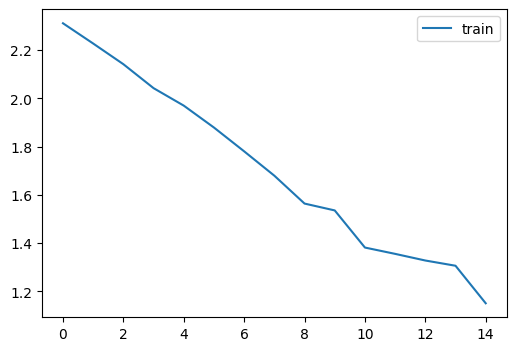

In [41]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

## TrainingLearner & MomentumLearner

In [42]:
#|export
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

In [43]:
#|export
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, cbs, lr=0.1, opt_func=optim.SGD, mom=0.80):
        self.mom = mom
        super().__init__(model, dls, loss_func,  cbs, lr=lr, opt_func=opt_func)
        
    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

accuracy,loss,epoch,train
0.595,1.470,0,True
0.774,0.783,0,False


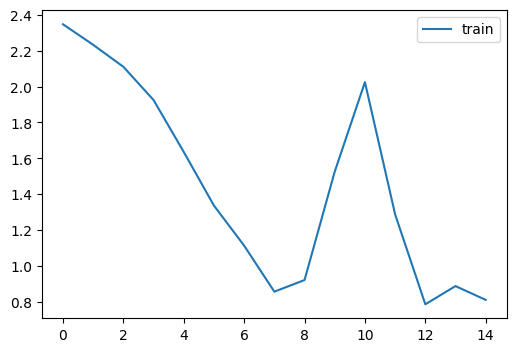

In [44]:
# NB: No TrainCB
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

## LRFinderCB

In [45]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3): fc.store_attr()
    
    def before_fit(self, learn):
        self.lrs, self.losses = [], []
        self.min = math.inf
    
    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min * 3: raise CancelFitException()
        for g in learn.opt.param_groups: g['lr'] *= self.lr_mult
    
    def plot(self):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

In [46]:
lrfind = LRFinderCB()
cbs = [DeviceCB(), ProgressCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-1, cbs=cbs)
learn.fit(1)

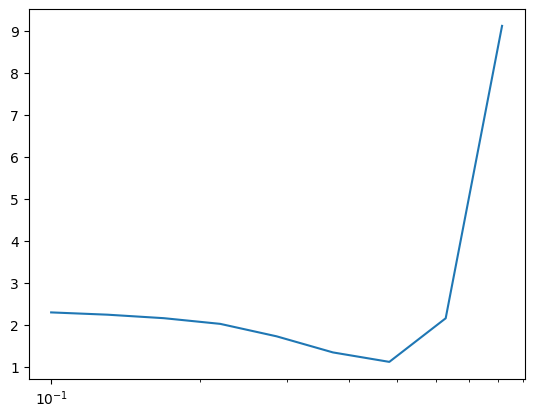

In [47]:
lrfind.plot()

In [48]:
#|export
from torch.optim.lr_scheduler import ExponentialLR

In [49]:
#|export
class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3): fc.store_attr()
    
    def before_fit(self, learn):
        self.sched = ExponentialLR(learn.opt, self.gamma)
        self.lrs, self.losses = [], []
        self.min = math.inf
    
    def after_batch(self, learn):
        if not learn.model.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min * self.max_mult: raise CancelFitException()
        self.sched.step()
    
    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

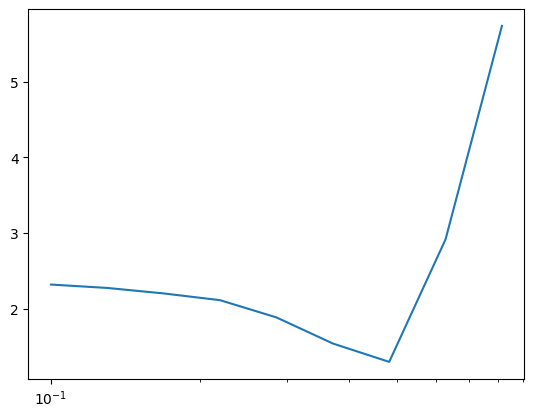

In [50]:
cbs = [DeviceCB()]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-1, cbs=cbs)
learn.fit(1, cbs=LRFinderCB())

In [51]:
#|export
@fc.patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

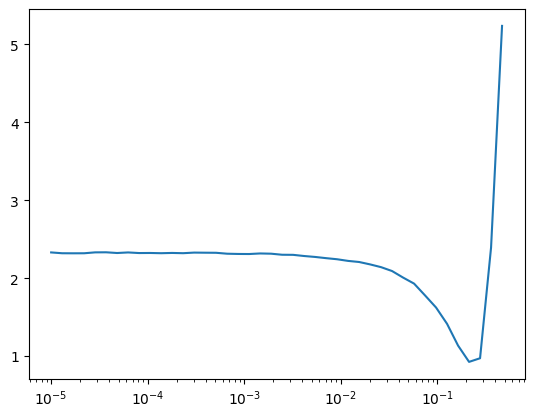

In [52]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=cbs).lr_find()

## Updated version since the lesson

After the lesson we noticed that `contextlib.context_manager` has a surprising "feature" which does not let us raise an Exception before `yield`. Therefore we have replaced the context manager with decorator in the updated version of `Learner`. We have also added a few more callbacks in `one_epoch()`  

In [53]:
#|export
class with_cbs:
    def __init__(self, nm): self.nm = nm
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        return _f

In [54]:
#|export
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl): self._one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

accuracy,loss,epoch,train
0.574,1.619,0,True
0.684,0.997,0,False


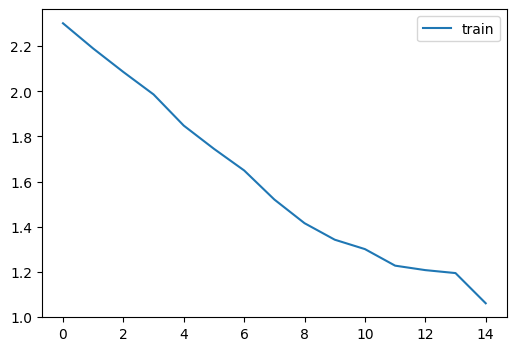

In [55]:
model = get_model()

metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

## Export

In [3]:
from nbdev import nbdev_export; nbdev_export()